# HW02 - Michelangelo Saveriano - eCommerce
## Load the libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import datetime

## Load the dataset

In [20]:
df_oct = pd.read_csv('./data/2019-Oct.csv', 
                     parse_dates = ['event_time'],
                     date_parser = pd.to_datetime)
df_nov = pd.read_csv('./data/2019-Nov.csv', 
                     parse_dates = ['event_time'],
                     date_parser = pd.to_datetime)
df = pd.concat([df_oct, df_nov])


In [23]:
df

,event_time,event_type,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...
67501974,2019-11-30 23:59:58+00:00,view,NaN,277.74,532714000,02b4131c-0112-4231-aafa-ceaa08e77c1b
67501975,2019-11-30 23:59:58+00:00,view,baden,62.81,545223467,734c5eef-0742-4f8b-9d22-48f75b0bc359
67501976,2019-11-30 23:59:59+00:00,view,samsung,167.03,557794415,6fecf566-ebb0-4e70-a243-cdc13ce044cb
67501977,2019-11-30 23:59:59+00:00,view,samsung,566.27,531607492,368ddc8b-5db9-40fb-b7ff-b6582a1192c0


## Additional features
### Event type features

In [24]:
df['cart'] = df['event_type'] == 'cart'
df['purchase'] = df['event_type'] == 'purchase'
df['view'] = df['event_type'] == 'view'

### Time features

In [25]:
df['month'] = [i.strftime("%B") for i in df['event_time']]
df['month_number'] = [i.month for i in df['event_time']]
df['hour'] = [i.hour for i in df['event_time']]
df['day_of_the_week'] = [i.strftime("%A") for i in df['event_time']]

### Category features

In [8]:
df['subcategory'] = ['.'.join(s.split('.')[1:]) if isinstance(s, str)  and '.' in s else None for s in df['category_code']]
df['category'] = [s.split('.')[0] if isinstance(s, str) else None for s in df['category_code']]

In [20]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_code', 'user_id',
       'cart', 'purchase', 'view', 'month', 'month_number', 'hour',
       'day_of_the_week', 'subcategory', 'category'],
      dtype='object')

# RQ1
### Which is the rate of complete funnels? 
To calculate the rate of complete funnels we can divide the number of purchases by the total number of views

In [8]:
rate_complete_funnels = df['purchase'].sum() / df['view'].sum()
print("The rate of complete funnels is %.2f%%" % (rate_complete_funnels*100))

The rate of complete funnels is 1.59%


### What’s the operation users repeat more on average within a session?
We calculate how many times each couple session-event occours then we group by the event_type and perform the mean.

In [9]:
mean_event_by_session = df.groupby(['user_session', 'event_type']).size().groupby('event_type').mean()

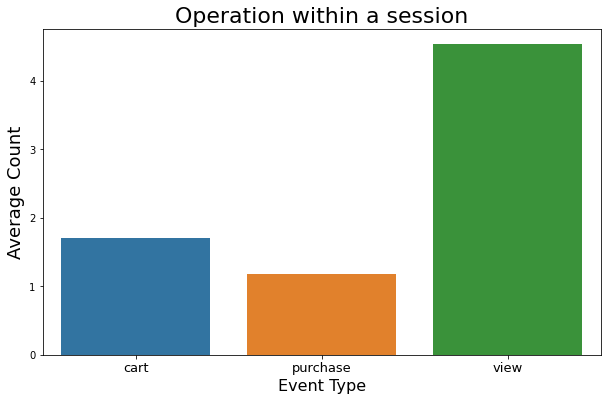

In [10]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=mean_event_by_session.index, y=mean_event_by_session.values)
plt.title('Operation within a session', fontsize=22)
plt.ylabel('Average Count', fontsize=18)
plt.xlabel('Event Type', fontsize=16)
plt.xticks(fontsize=13);

In [11]:
for oper, avg in mean_event_by_session.items():
    print("The users perform the '%s' operation %.3f times each session." % (oper, avg))

The users perform the 'cart' operation 1.708 times each session.
The users perform the 'purchase' operation 1.183 times each session.
The users perform the 'view' operation 4.535 times each session.


### How many times, on average, a user views a product before adding it to the cart?
To answer this question, we can calculate for each user-product pair the ratio between the number of "view" and the number of "cart" operations and therefore the average over these values

In [ ]:
user_prod_pairs = df.groupby(['user_id', 'product_id'])[["view", "cart", "purchase"]].sum()
filt_cart_positive = user_prod_pairs['cart'] > 0
user_prod_pairs_filtered = user_prod_pairs[filt_cart_positive]
average_ratio = (user_prod_pairs_filtered['view'] / user_prod_pairs_filtered['cart']).mean()

In [9]:
print("A user, on average, view %.2f times a product before adding it to the cart" % average_ratio)

A user, on average, view 3.75 times a product before adding it to the cart


### What’s the probability that products added once to the cart are effectively bought?
Using the user-product pairs defined above we calculate how many pairs have both been carted and purchased.

In [10]:
prob_purch_given_cart = (user_prod_pairs[filt_cart_positive]['purchase'] > 0).mean()

In [11]:
print("The probability that a product added to the cart will be purchased is %.2f%%" % (prob_purch_given_cart*100))

The probability that a product added to the cart will be purchased is 41.40%


### What’s the average time an item stays in the cart before being removed?
Unfortunately there aren't 'remove_from_cart' events in the dataset, for this reason, we will calculate the average time an item stays in the cart before being purchased. 
<br/>
To do that we find each possible pair user-product so we calculate the difference between the first time the user added the product in the cart and the first time the user purchased the product and then we compute the average over these differences.

In [12]:
pairs_user_product = df[df['view'] == False].groupby(['user_id', 'product_id', 'cart', 'purchase'])
first_pairs_user_product = pairs_user_product['event_time'].min().reset_index()
time_diffs = []
for _, _d in first_pairs_user_product.groupby(['user_id', 'product_id']):
    if len(_d) == 2:
        cart_time = _d[_d['cart']]['event_time'].values[0]
        purchase_time = _d[_d['purchase']]['event_time'].values[0]
        if cart_time < purchase_time:
            time_diffs.append(purchase_time - cart_time)
avg_time = np.mean(time_diffs).astype('timedelta64[m]')
print("An item stays in the cart, on average,", avg_time, ".")

An item stays in the cart, on average, 126 minutes .


### How much time passes on average between the first view time and a purchase/addition to cart?
To do that we find each possible pair user-product so we calculate the difference between the first time the user view the product and the first time the user added the product in the cart and then we compute the average over these differences.

In [13]:
pairs_user_product = df[df['purchase'] == False].groupby(['user_id', 'product_id', 'view', 'cart'])
first_pairs_user_product = pairs_user_product['event_time'].min().reset_index()
time_diffs = []
for _, _d in first_pairs_user_product.groupby(['user_id', 'product_id']):
    if len(_d) == 2:
        cart_time = _d[_d['view']]['event_time'].values[0]
        purchase_time = _d[_d['cart']]['event_time'].values[0]
        if cart_time < purchase_time:
            time_diffs.append(purchase_time - cart_time)
avg_time = np.mean(time_diffs).astype('timedelta64[m]')
print("Between the first view time and the addition to the cart passes, on average,", avg_time, ".")

Between the first view time and the addition to the cart passes, on average, 21 minutes .


# RQ2
### What are the categories of the most trending products overall?
We find the 100 most purchased products and then we plot their categories.

In [11]:
top_products = df.groupby(['product_id', 'category_code'])['purchase'].sum().sort_values(ascending=False).iloc[:100]
trending_categories = top_products.groupby('category_code').count().sort_values(ascending=False)

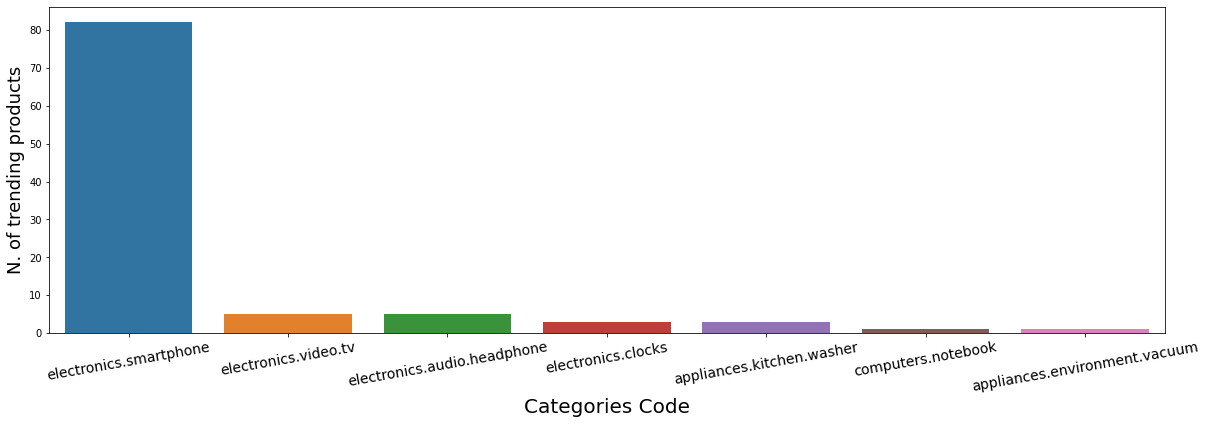

In [12]:
plt.figure(figsize=(20,6))
sns.barplot(x=trending_categories.index, y=trending_categories.values)
plt.xlabel('Categories Code', fontsize=20)
plt.ylabel('N. of trending products', fontsize=18)
plt.xticks(rotation=10, fontsize=14);

The vast majority of the trending (i.e. purchased) products are smartphones.
### For each month visualize this information through a plot showing the number of sold products per category. 
For each month we calculate the number of purchased product per category.

In [14]:
count_sold_categories_code = df.groupby(['month', 'category_code'])['purchase'].sum().reset_index()
months = df['month'].unique()

Then we iterate over the months plotting this information.
#### Number of sold products per sub-category 

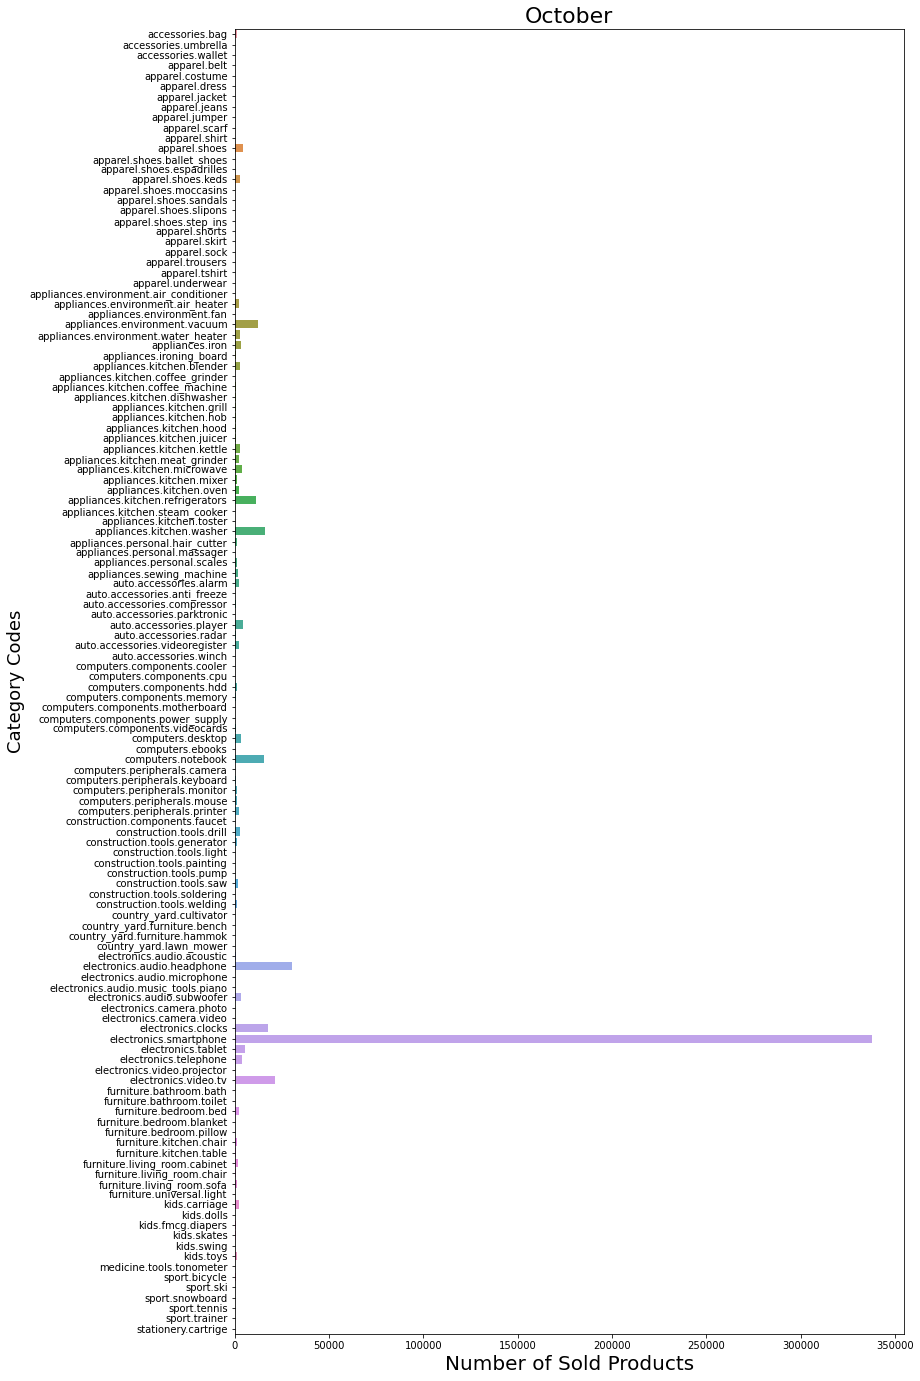

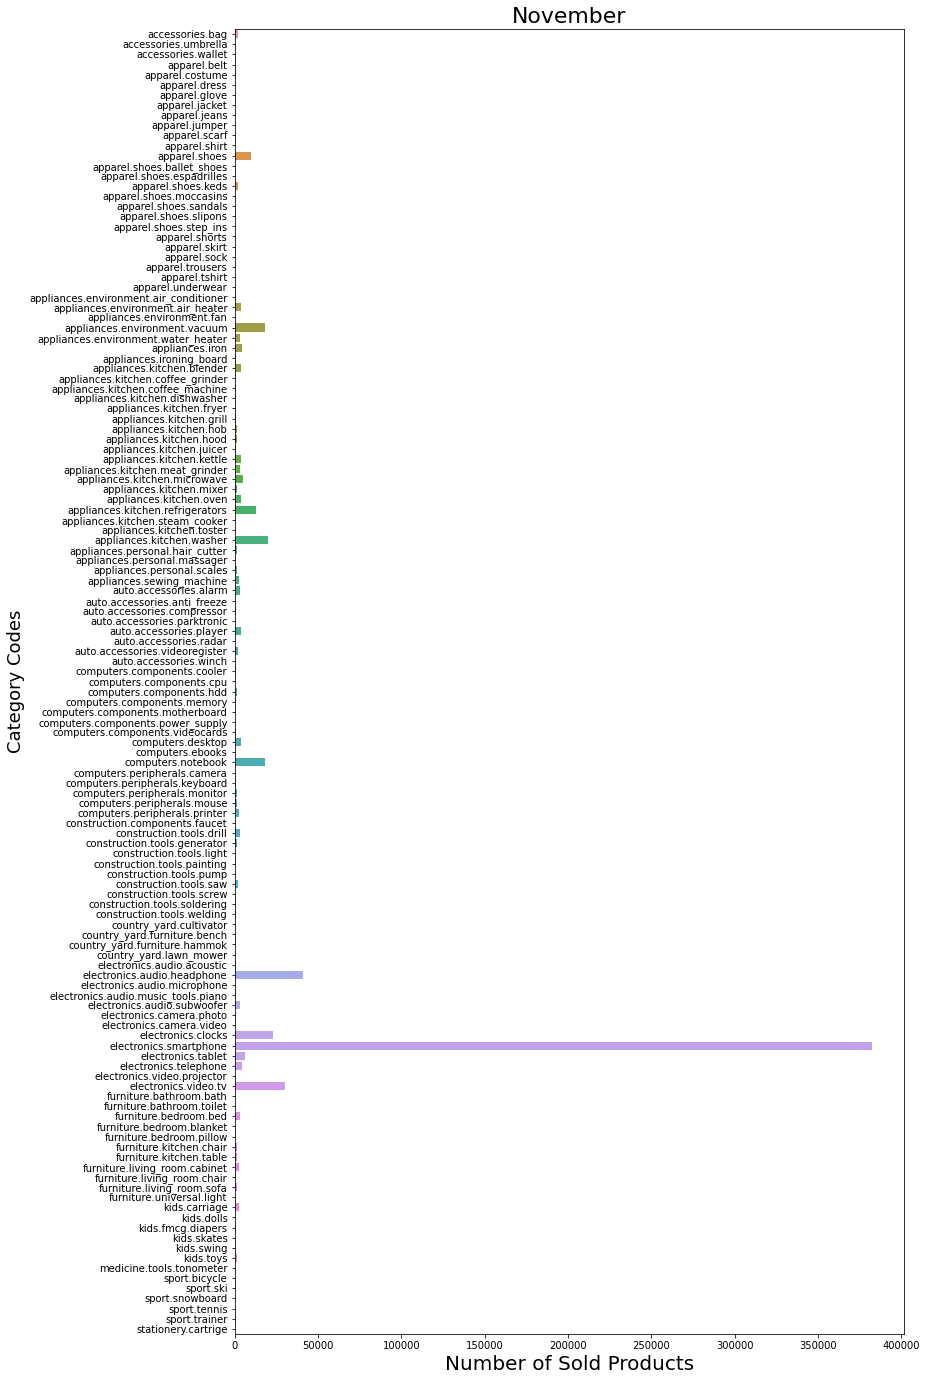

In [15]:
for i in range(months.size):
    plt.figure(figsize=(12, 24))
    filt_month = count_sold_categories_code['month'] == months[i]
    ax = sns.barplot(data=count_sold_categories_code[filt_month], x='purchase', y='category_code', orient='h')
    plt.xlabel("Number of Sold Products", fontsize=20)
    plt.ylabel("Category Codes", fontsize=18)
    plt.title(months[i], fontsize=22)

#### Number of sold products per category

In [17]:
count_sold_category = df.groupby(['month', 'category'])['purchase'].sum().reset_index()

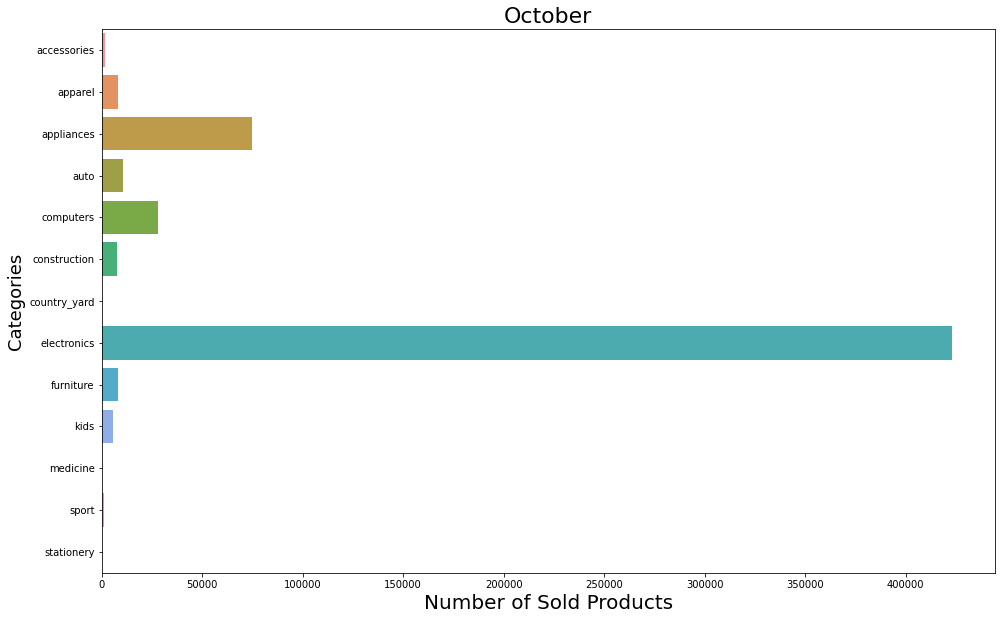

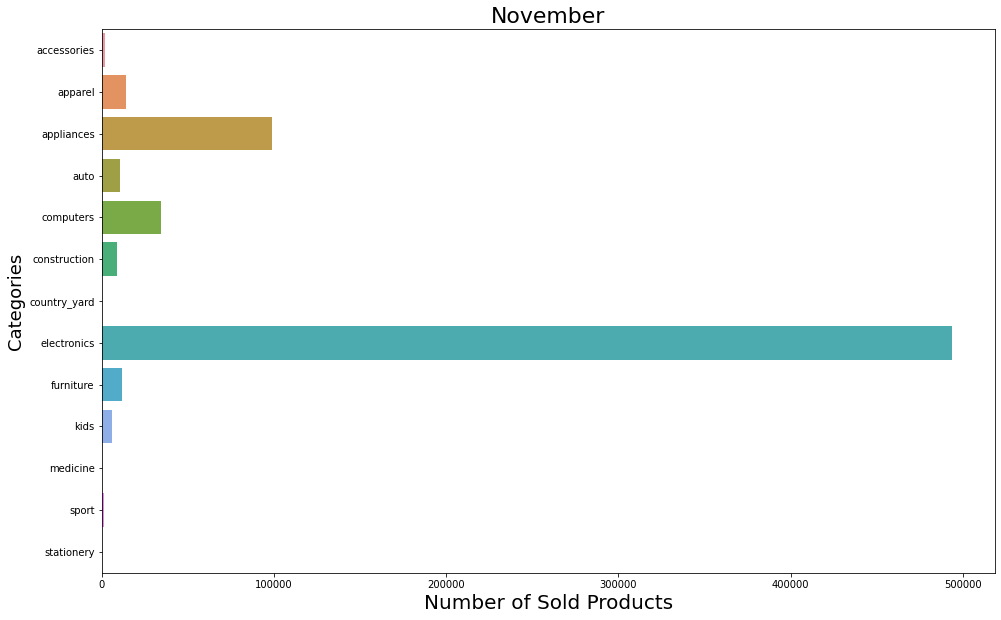

In [18]:
for i in range(months.size):
    plt.figure(figsize=(16, 10))
    filt_month = count_sold_category['month'] == months[i]
    ax = sns.barplot(data=count_sold_category[filt_month], x='purchase', y='category', orient='h')
    plt.xlabel("Number of Sold Products", fontsize=20)
    plt.ylabel("Categories", fontsize=18)
    plt.title(months[i], fontsize=22)

### Plot the 10 most visited subcategories
For each subcategory we calculate the number of views and then we plot the 10 most visited

In [32]:
most_visited_subcategories = df.groupby(['subcategory'])['view'].sum().sort_values(ascending=False).iloc[:10]

Most of the traffic comes from the 'smartphone' subcategory.


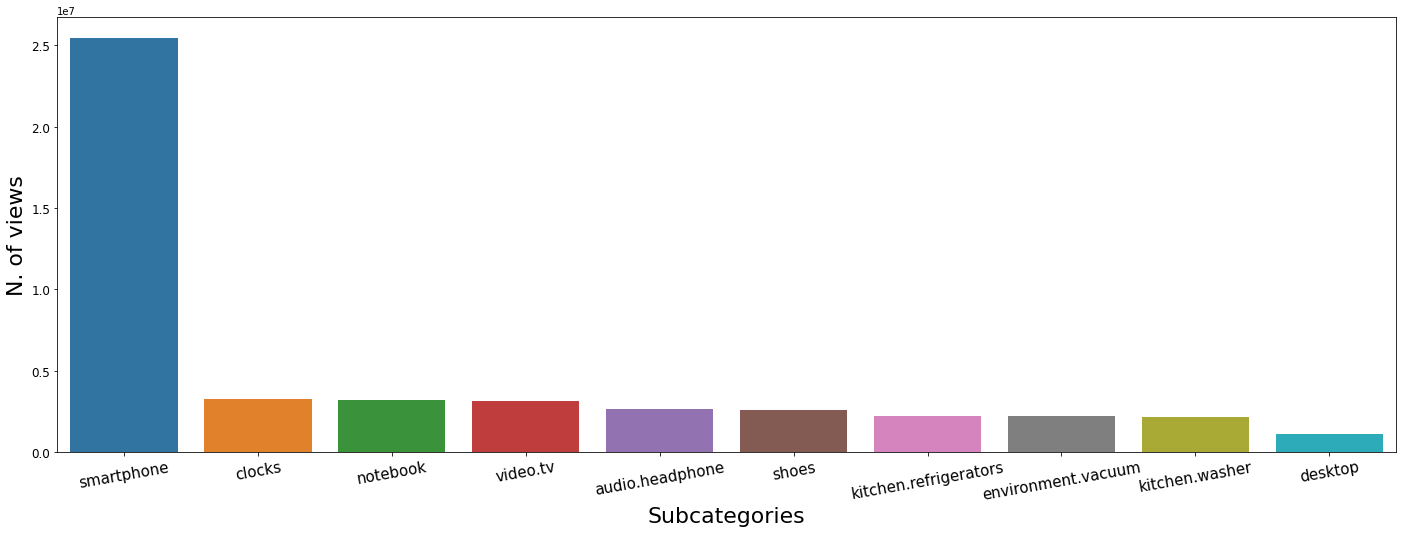

In [34]:
plt.figure(figsize=(24,8))
sns.barplot(x=most_visited_subcategories.index, y=most_visited_subcategories.values)
plt.xlabel('Subcategories', fontsize=22)
plt.ylabel('N. of views', fontsize=22)
plt.xticks(rotation=10, fontsize=15)
plt.yticks(fontsize=12)
print("Most of the traffic comes from the '%s' subcategory." % most_visited_subcategories.index[0]);

### Plot the 10 most sold products per category
For each pair category-product we calculate the number of purchases then we iterate over the new dataset and plot the 10 most sold product per category

In [20]:
most_sold_product = df.groupby(['category', 'product_id'])['purchase'].sum().reset_index()
categories = df['category'].unique()

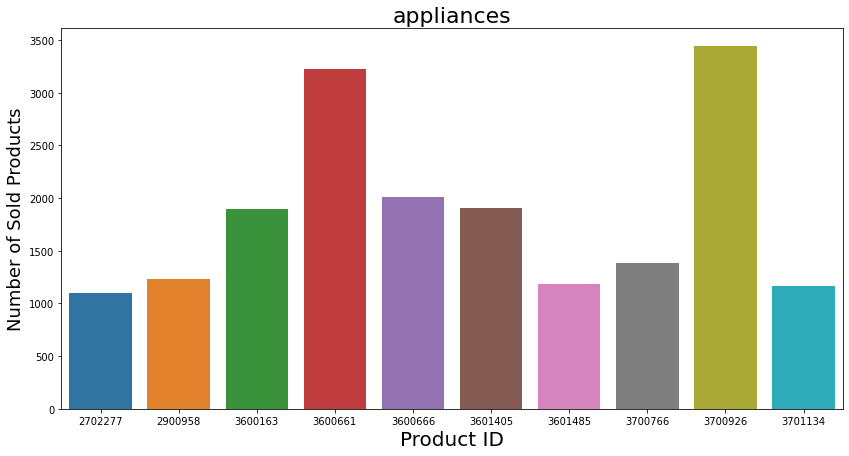

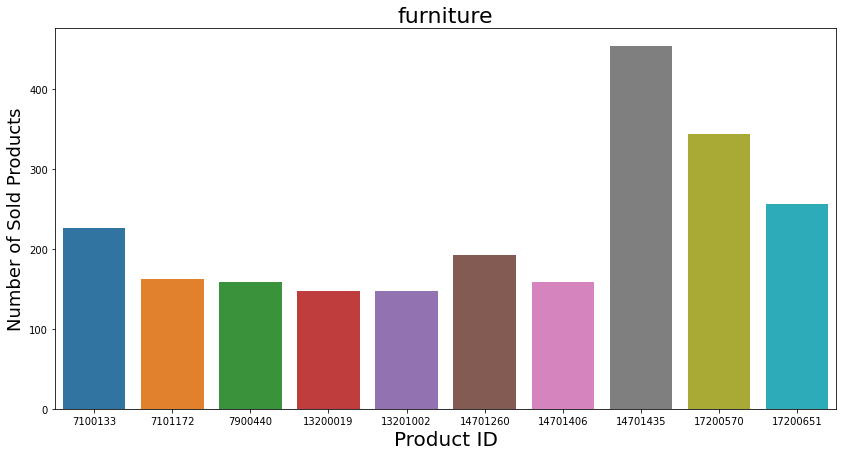

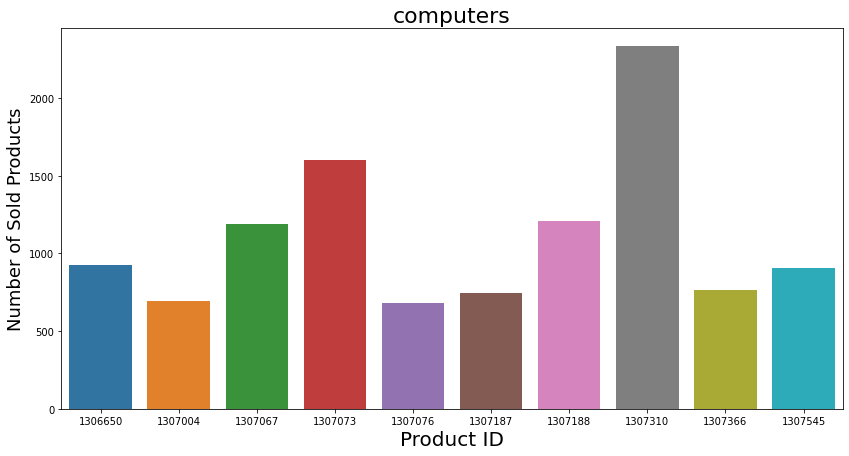

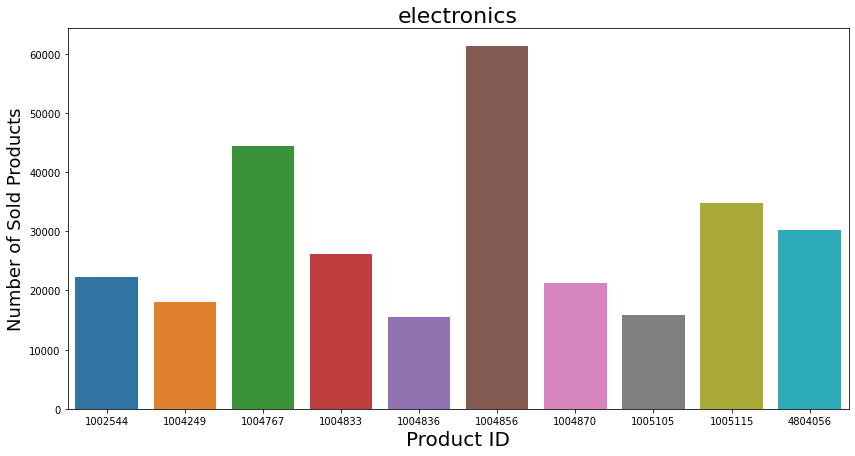

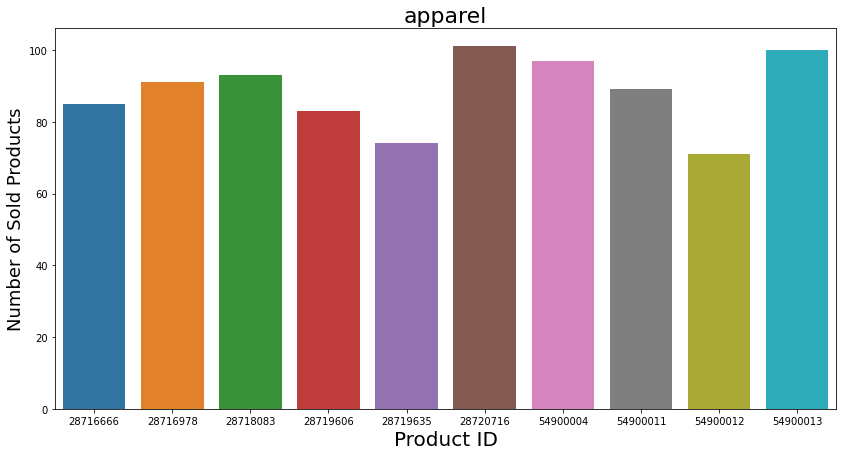

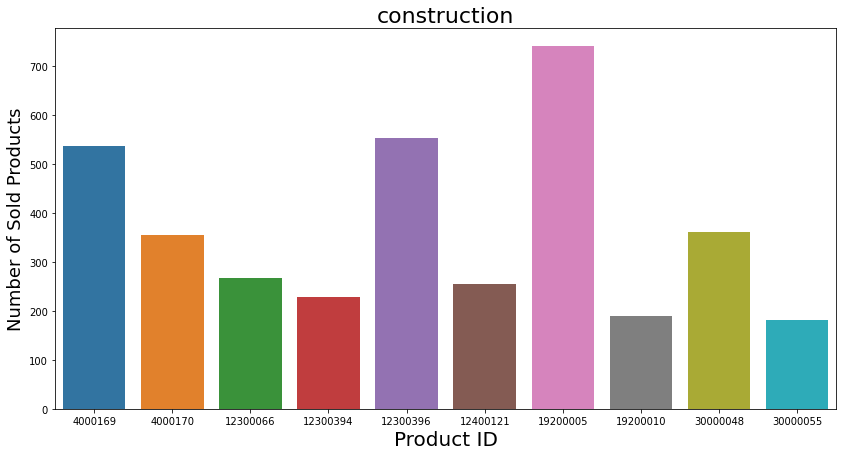

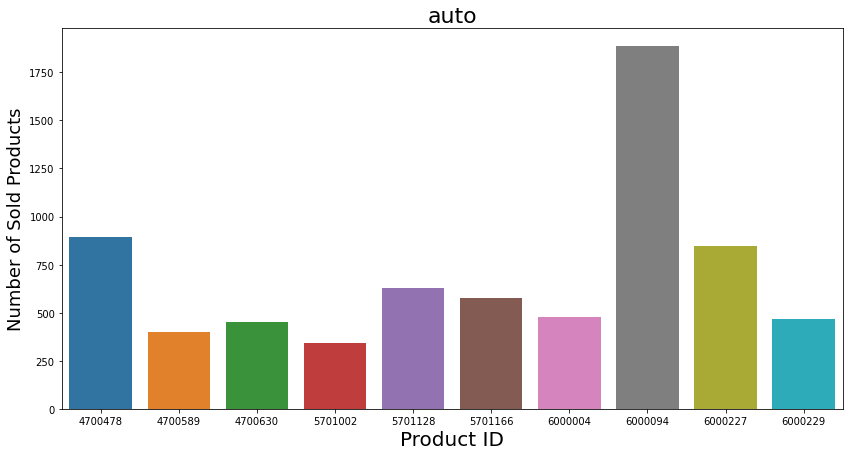

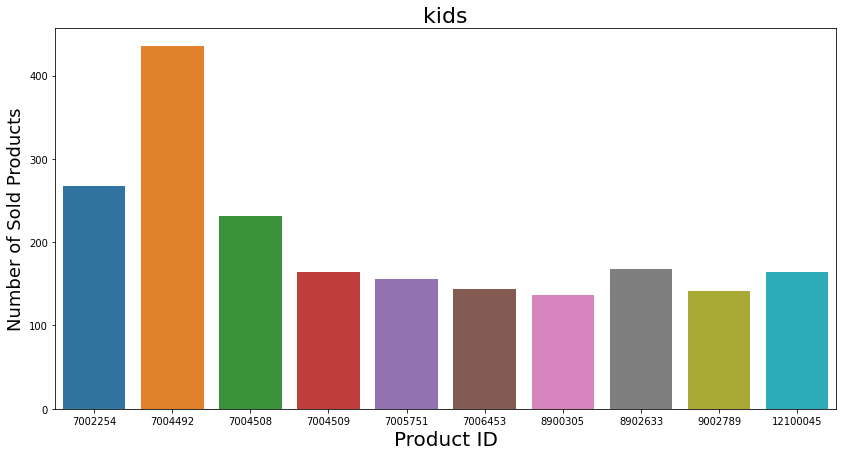

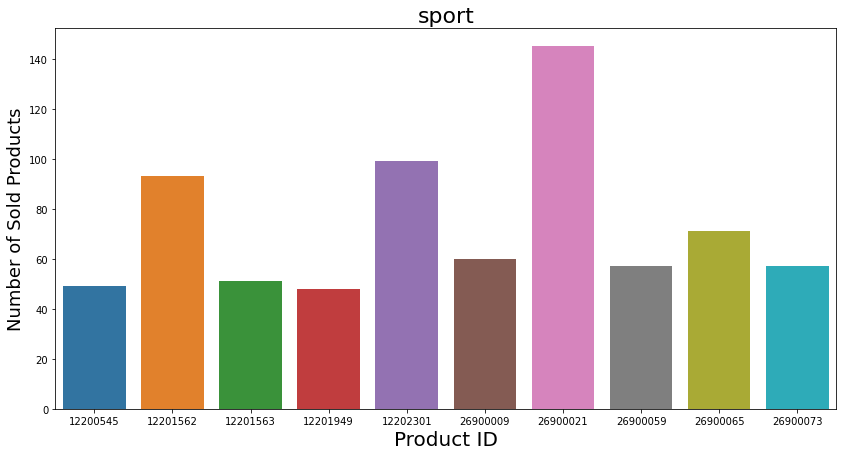

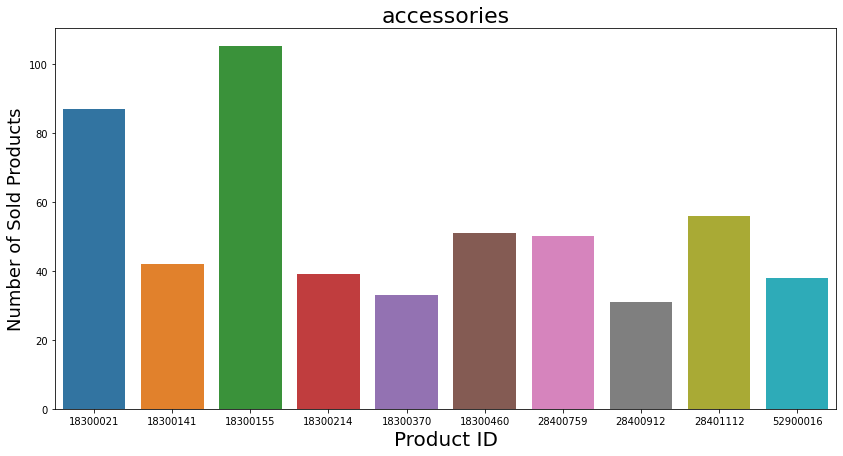

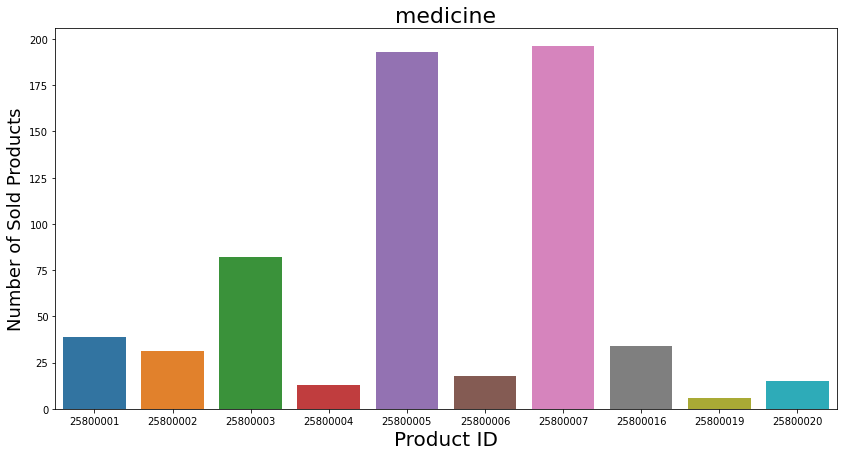

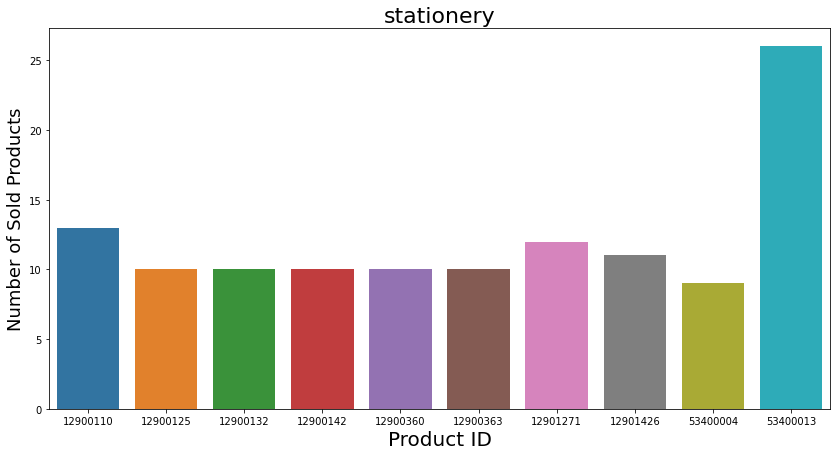

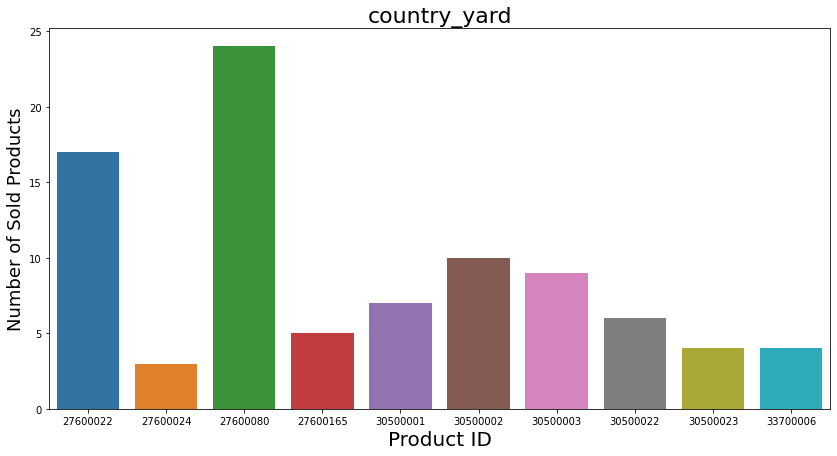

In [21]:
for i in range(categories.size):
    filt_categ = most_sold_product['category'] == categories[i]
    d = most_sold_product[filt_categ].sort_values('purchase', ascending=False).iloc[:10]
    if len(d):
        plt.figure(figsize=(14, 7))
        sns.barplot(data=d, x='product_id', y='purchase')
        plt.xlabel("Product ID", fontsize=20)
        plt.ylabel("Number of Sold Products", fontsize=18)
        plt.title(categories[i], fontsize=22)

The majority categories generate quite little sale numbers, in fact most of the sold products are electronic products.

# RQ3
### For each category, what’s the brand whose prices are higher on average? 
Since there are some products that occur more frequently in the dataset than others, we first find the average price of each product and then calculate the average price of each brand's product.

In [8]:
category_brand_product_price = df.groupby(['category', 'brand', 'product_id'])['price'].mean().reset_index()
category_brand_mean_price = category_brand_product_price.groupby(['category', 'brand'])['price'].mean().reset_index()

In [11]:
for i in range(1, categories.size):
    filt_categ = category_brand_mean_price['category'] == categories[i]
    category, brand, avg_price = category_brand_mean_price[filt_categ].nlargest(1, 'price').iloc[0]
    print("In the category '%s' the brand with the highest average prices = %.2f is '%s'" % (category, avg_price, brand))

In the category 'appliances' the brand with the highest average prices = 1674.29 is 'cooperhunter'
In the category 'furniture' the brand with the highest average prices = 1987.29 is 'senspa'
In the category 'computers' the brand with the highest average prices = 2187.50 is 'dreammachines'
In the category 'electronics' the brand with the highest average prices = 1855.03 is 'rado'
In the category 'apparel' the brand with the highest average prices = 958.57 is 'sergiorossi'
In the category 'construction' the brand with the highest average prices = 2032.76 is 'helix'
In the category 'auto' the brand with the highest average prices = 863.20 is 'remeza'
In the category 'kids' the brand with the highest average prices = 1801.82 is 'hartan'
In the category 'sport' the brand with the highest average prices = 2533.24 is 'pinarello'
In the category 'accessories' the brand with the highest average prices = 514.17 is 'weekend'
In the category 'medicine' the brand with the highest average prices = 7

### Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.
We use the same process as before but in this case the category is set by input.

In [12]:
def plot_brands_average_price(df, category):
    filt_categ = df['category'] == category
    brand_product_price = df[filt_categ].groupby(['brand', 'product_id'])['price'].mean().reset_index()
    brand_mean_price = brand_product_price.groupby('brand')['price'].mean().reset_index()
    fig = plt.figure(figsize=(15, int(len(brand_mean_price)/5)+1))
    ax = sns.barplot(data=brand_mean_price, x='price', y='brand', orient='h')
    ax.set_xlabel('Average Price', fontsize=20)
    ax.set_ylabel('Brand', fontsize=20)
    ax.set_title("Average Prices in %s" % category.capitalize())
    return ax, fig

Here there is an example

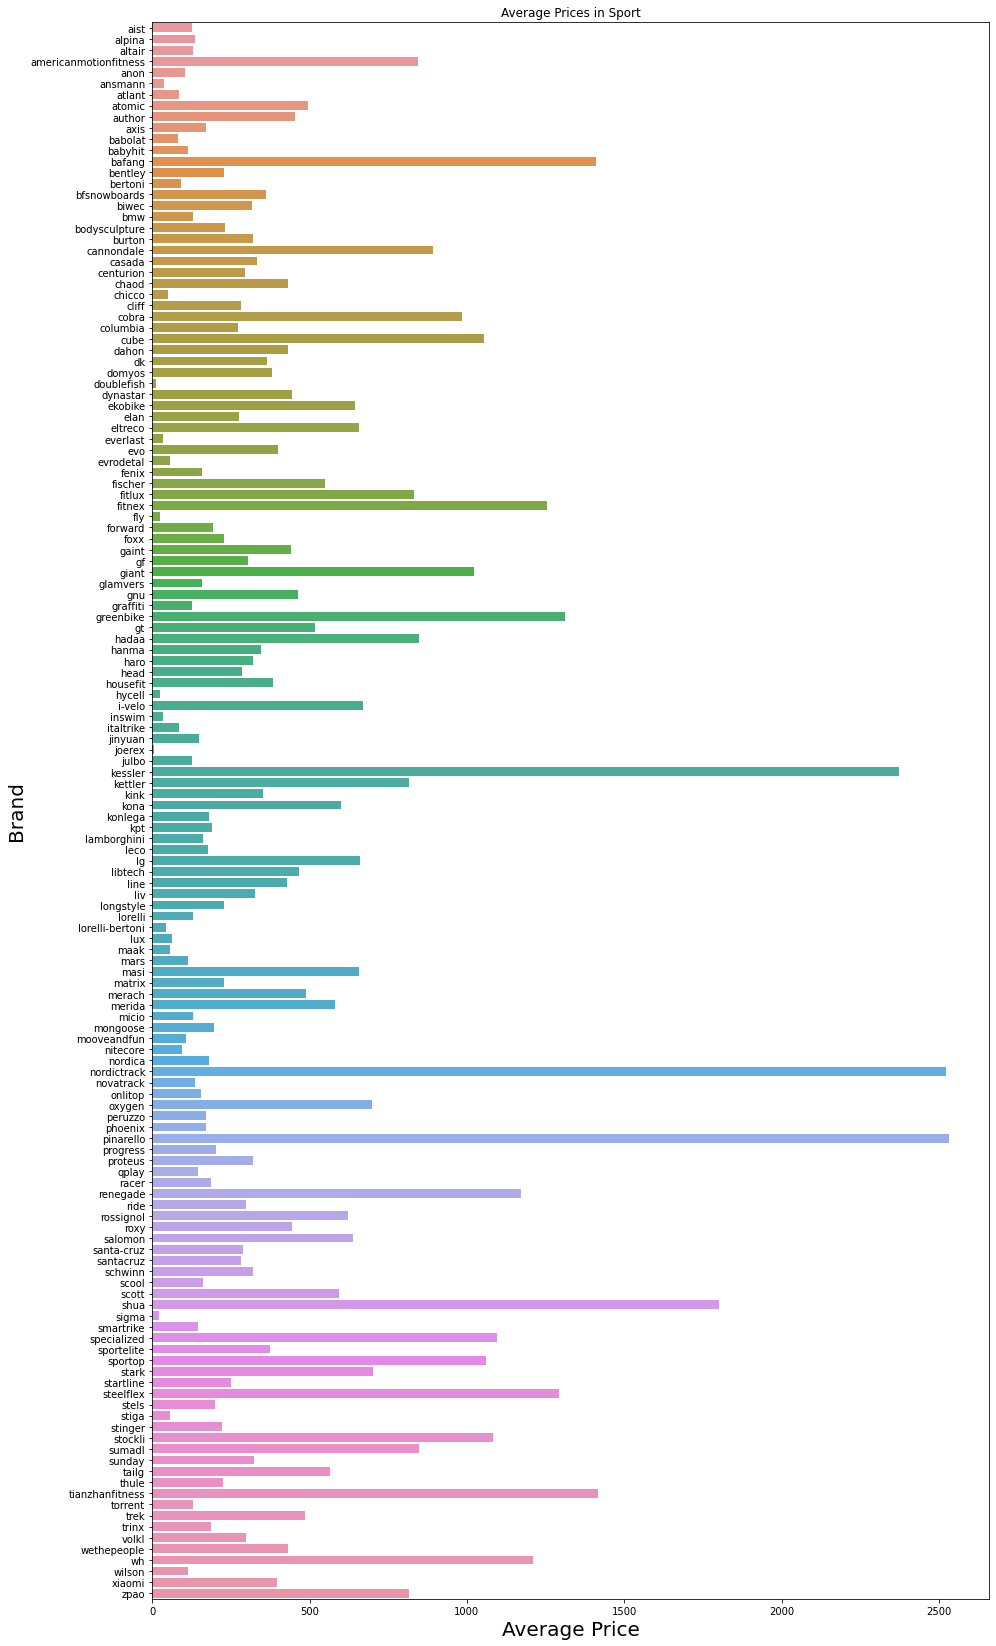

In [13]:
plot_brands_average_price(df, category='sport');

### Find, for each category, the brand with the highest average price.
For each category we find in the category_brand_mean_price, defined before, the brand with the highest average price then we plot the results in ascending order.

In [14]:
brand_prices = pd.DataFrame()
for i in range(1, categories.size):
    filt_categ = category_brand_mean_price['category'] == categories[i]
    brand_prices = brand_prices.append(category_brand_mean_price[filt_categ].nlargest(1, 'price'))
brand_prices['category_brand'] = brand_prices['category'] + ' : ' + brand_prices['brand']
brand_prices = brand_prices.sort_values('price')

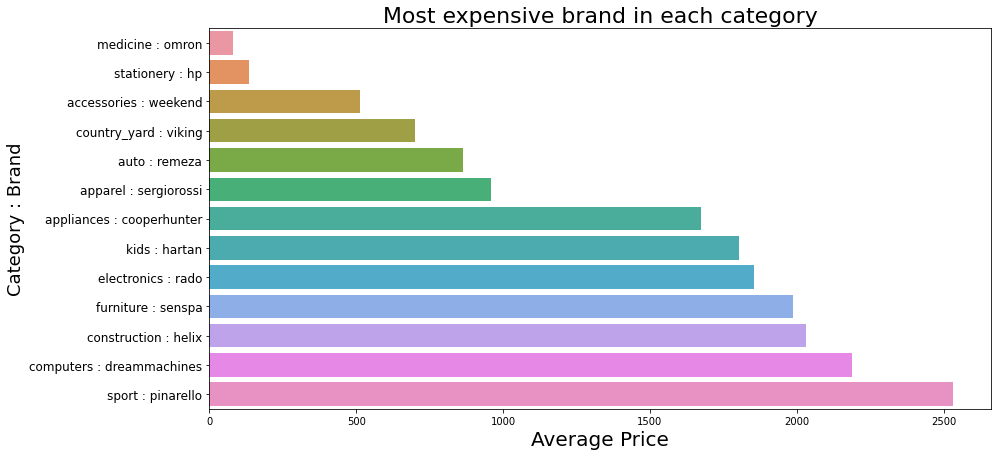

In [15]:
plt.figure(figsize=(14, 7))
sns.barplot(data=brand_prices, x='price', y='category_brand', orient='h')
plt.xlabel("Average Price", fontsize=20)
plt.ylabel("Category : Brand", fontsize=18)
plt.yticks(fontsize=12)
plt.title('Most expensive brand in each category', fontsize=22);

As shown in the plot above there are huge differences in the average prices of different brands.

# RQ4
### Write a function that given the name of a brand in input returns, for each month, its profit.
To do this, we first find the products of the brand that have been purchased and then calculate the profit by adding, for each month, the price of the product found earlier.

In [41]:
def brand_profit(df, brand_name):
    brand_products = df[df['brand'] == brand_name]
    brand_sold_products = brand_products[brand_products['purchase'] == True]
    res = brand_sold_products.groupby(['month', 'month_number'])['price'].sum().reset_index()
    return res.sort_values('month_number').rename(columns={'price': 'profit'}).reset_index()[['month', 'profit']]

Here you can see an example

In [34]:
brand_profit(df, 'apple')

,month,profit
0,October,1.112093e+08
1,November,1.275125e+08


### Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next
In order to calculate the loss and the percentage loss between one month and the next we call for each brand the function defined above, then we compute the difference and the percentage change over the profits and we store the results in the earnings_variation variable.

In [ ]:
brands = df['brand'].unique()
earnings_variation = pd.DataFrame()
for i in range(len(brands)):
    brandProfit = brand_profit(df, brands[i])
    print(i)
    
    losses = brandProfit['profit'].diff().reset_index().iloc[1:]
    pct_losses = brandProfit['profit'].pct_change().reset_index().iloc[1:]

    brand_losses = pd.DataFrame()
    brand_losses['pct_loss'] = pct_losses['profit']
    brand_losses['loss'] = losses['profit']
    brand_losses['month_2'] = brandProfit['month'][losses['index'].values].values
    brand_losses['month_1'] = brandProfit['month'][losses['index'].values - 1].values
    brand_losses['brand'] = brands[i]
    earnings_variation = earnings_variation.append(brand_losses)

We then print the top 3 brands that have suffered the greatest losses and those that have suffered the greatest losses percentages.

In [60]:
print("The biggest percentage losses:")
for i in earnings_variation.nsmallest(3, 'pct_loss').values:
    print(" - %s lost %.2f%% (%.2f) between %s and %s." % (i[-1], i[0]*-100, i[1], i[3], i[2]))

The biggest percentage losses:
 - jonnesway lost 96.62% (-3720.81) between October and November.
 - sunfull lost 96.00% (-1297.44) between October and November.
 - evga lost 95.90% (-14141.94) between October and November.


In [61]:
print("The biggest losses:")
for i in earnings_variation.nsmallest(3, 'loss').values:
    print(" - %s lost %.2f%% (%.2f) between %s and %s." % (i[-1], i[0]*-100, i[1], i[3], i[2]))

The biggest losses:
 - acer lost 6.41% (-229412.99) between October and November.
 - peda lost 77.99% (-171063.43) between October and November.
 - omabelle lost 41.94% (-145833.74) between October and November.


# RQ5
### In what part of the day is your store most visited?
We count the number of user sessions (i.e. the number of user connected) for each hour of the day for each day of the week, then we plot the results.

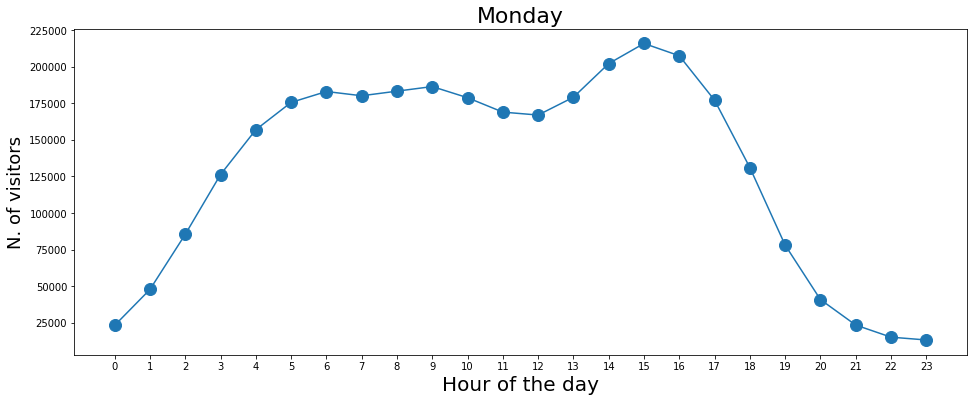

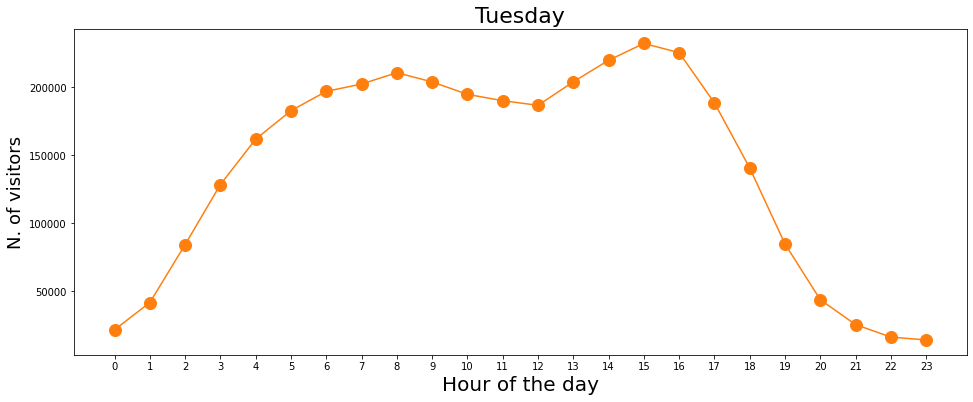

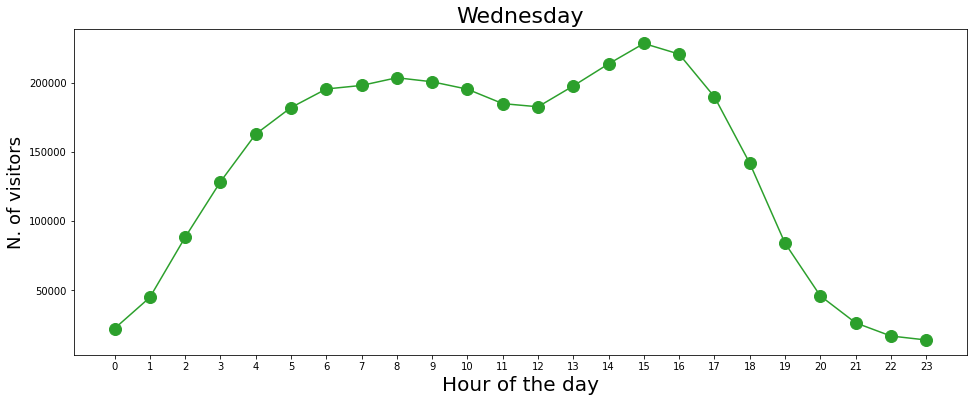

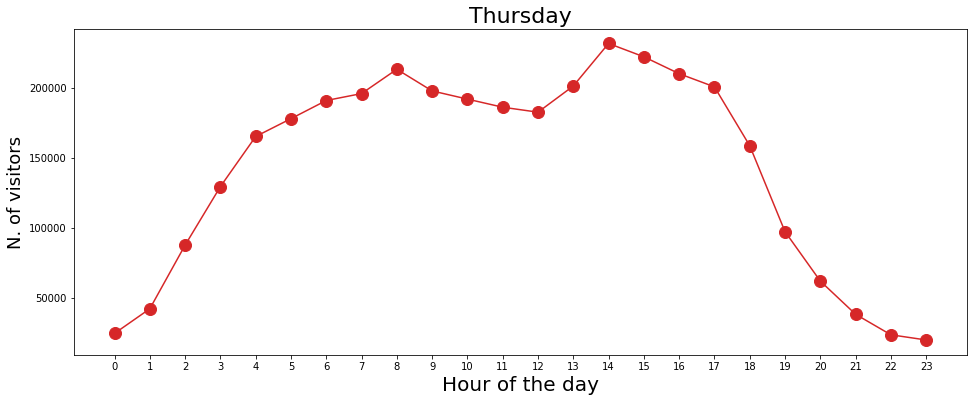

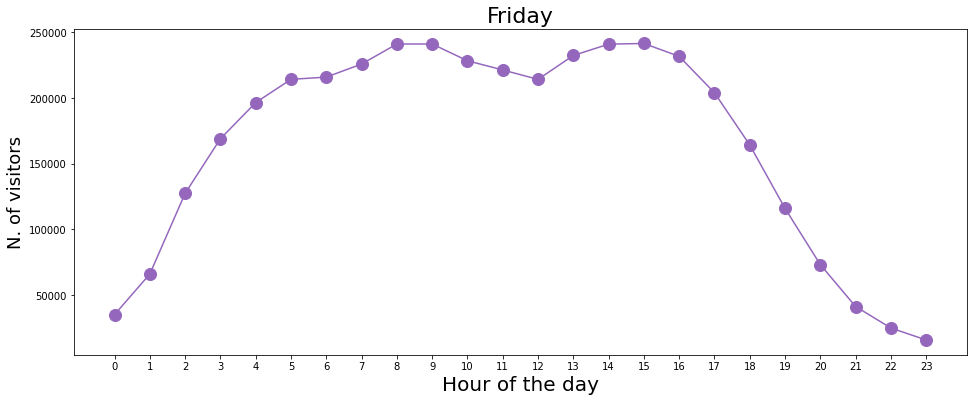

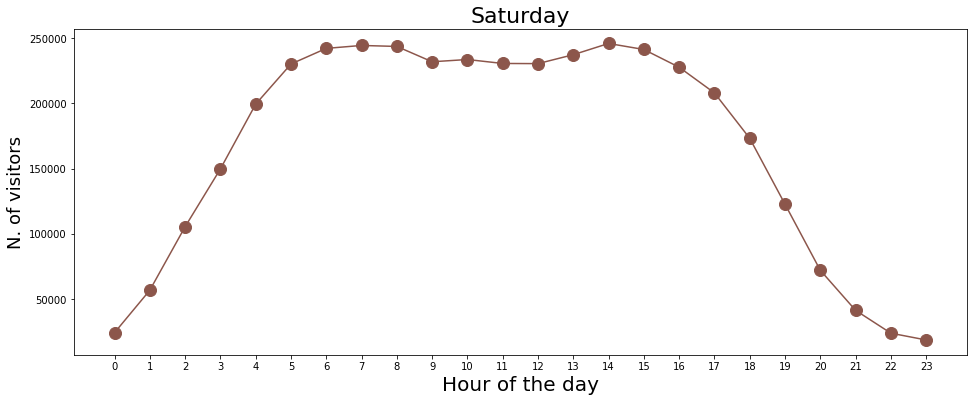

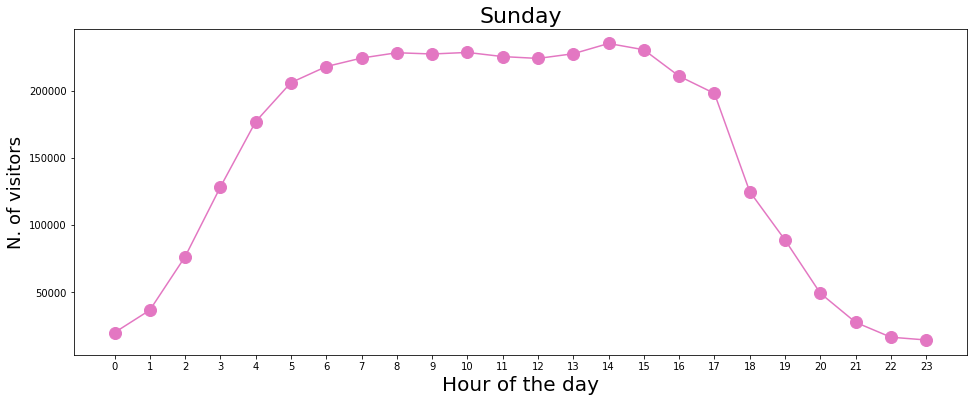

In [65]:
weekDays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
colors = list(matplotlib.colors.TABLEAU_COLORS.keys())
for weekday in weekDays:
    plt.figure(figsize=(16, 6))
    filt_day = df_['day_of_the_week'] == weekday
    d = df_[filt_day].groupby(['hour'])['user_session'].nunique().reset_index()
    plt.plot(d['hour'], d['user_session'], "-o", markersize = 12, color=colors[weekDays.index(weekday)])
    plt.xlabel("Hour of the day", fontsize=20)
    plt.ylabel("N. of visitors", fontsize=18)
    plt.xticks(np.arange(0, 24))
    plt.title(weekday, fontsize=22)

# RQ6
### What's the conversion rate of your online store?
The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited.

In [15]:
conversion_rate = df['purchase'].sum() / df['view'].sum()
print("The conversion rate of the store is %.2f%%" % (conversion_rate*100))

The conversion rate of the store is 1.59%


### Plot the number of purchases of each category
For each category we calculate the number of views, the number of purchases and the conversion rate given by the ratio between these two.

In [25]:
categories_info = df.groupby('category')[['view', 'purchase']].sum() 
categories_info['converion_rate'] = categories_info['purchase'] / categories_info['view'] * 100
categories_info = categories_info.reset_index()

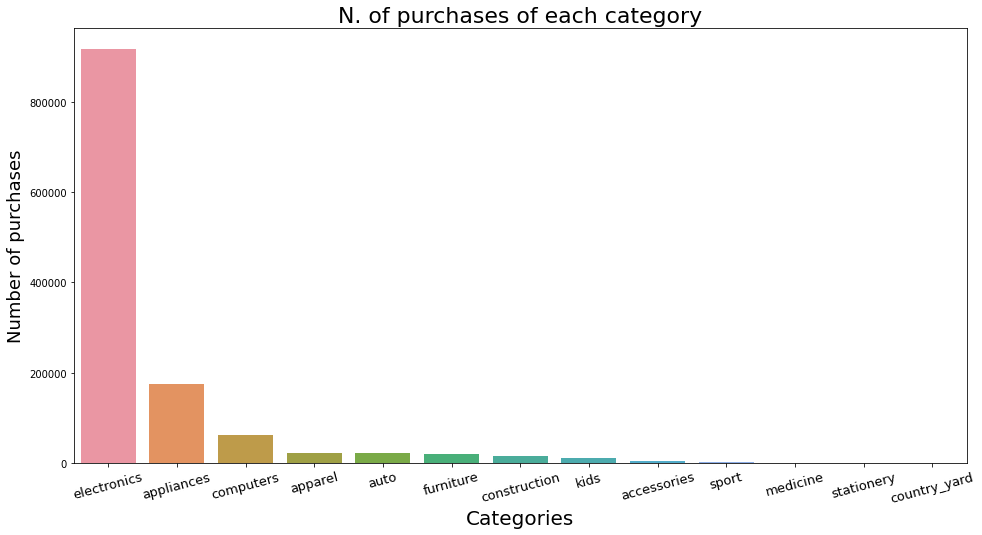

In [26]:
plt.figure(figsize=(16, 8))
sns.barplot(data=categories_info.sort_values('purchase', ascending=False), 
            x='category', y='purchase')
plt.xlabel("Categories", fontsize=20)
plt.ylabel("Number of purchases", fontsize=18)
plt.xticks(fontsize=13, rotation=15)
plt.title('N. of purchases of each category', fontsize=22);

### Plot conversion rate of each category

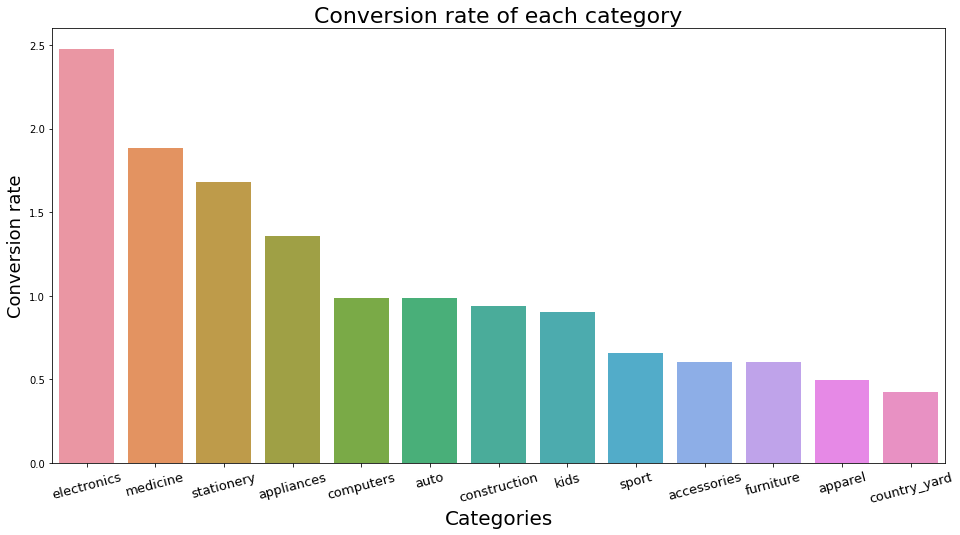

In [27]:
plt.figure(figsize=(16, 8))
sns.barplot(data=categories_info.sort_values('converion_rate', ascending=False), 
            x='category', y='converion_rate')
plt.xlabel("Categories", fontsize=20)
plt.ylabel("Conversion rate", fontsize=18)
plt.xticks(fontsize=13, rotation=15)
plt.title('Conversion rate of each category', fontsize=22);

# RQ7
### Prove that the pareto principle applies to your store
In order to prove the pareto principle we calculate the 80% of the store's earnings, the incomes generated by the top 20% of the customers that spend the most on our site and we compare these quantities.

In [27]:
purchases = df[df['purchase'] == True]
total_revenues = purchases['price'].sum()
customers = purchases.groupby('user_id')['price'].sum().sort_values(ascending=False).reset_index()
n_customers = len(customers)

In [28]:
print("The store's earnings are %.2f, so 80%% of that is %.2f" % (total_revenues, total_revenues*0.8))

The store's earnings are 505152392.77, so 80% of that is 404121914.22


In [29]:
print("The total number of customers is %d" % n_customers)

The total number of customers is 697470


Now we calculate the earnings generated by the top 20% of the users.

In [30]:
top_user_profit = customers.iloc[:int(n_customers*0.2)]['price'].sum()
print("The top 20%% of the user generates %.2f of incomes" % top_user_profit)

The top 20% of the user generates 364222233.81 of incomes


The incomes generated by the top 20% of the users is pretty close to the 80% of all the store earnings so this prove that the pareto principle is true in our case.